In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
# import MNIST digits (partial) dataset (comes with colab)
data = np.loadtxt(open('C:\MyPythonCoding\MyCoding\data\mnist_10k.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize to range of [0 1]
dataNorm = data / np.max(data)

#reshape to 2D greyscale images
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

Create train/test groups using DataLoader

In [4]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: bundle into Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate to DataLoaders
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

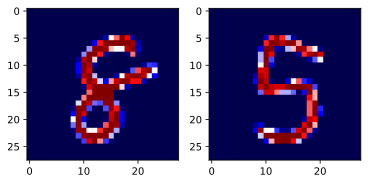

In [6]:
# display data

# grab one image data
tmp1 = test_loader.dataset.tensors[0][0,:]
tmp2 = test_loader.dataset.tensors[0][1,:]

fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(torch.squeeze(tmp1), cmap='seismic')
ax[1].imshow(torch.squeeze(tmp2), cmap='seismic')

plt.show()

Create the DL model class...

In [7]:
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,8,kernel_size=5,stride=3,padding=1)
      self.conv2 = nn.Conv2d(8,12,kernel_size=5,stride=1,padding=1)

      self.fc1 = nn.Linear(12*2*2,11)

      self.out = nn.Linear(11,10)

      self.print = printtoggle

    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      # # convolution -> maxpool -> relu
      # x = F.relu(F.max_pool2d(self.conv2(x),2))
      # print(f'Layer conv2: {x.shape}') if self.print else None

      # convolution -> relu
      x = F.relu(self.conv2(x))
      print(f'Layer conv2: {x.shape}') if self.print else None

      # vectorise for fc1 linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      print(f'Vectorize: {x.shape}') if self.print else None

      # linear layers fc1 and output
      x = F.relu(self.fc1(x))
      print(f'Layer fc1: {x.shape}') if self.print else None
      x = self.out(x)
      print(f'Layer out: {x.shape}') if self.print else None

      return x

  # create the model instance
  net = mnistNet(printtoggle)

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [9]:
# sanity checks to view layer sizes

netTEST,_,_ = createTheMNISTNet(True) #<----create instance with printout
print(netTEST)
summary(netTEST, (1,28,28))

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU if available
netTEST = netTEST.to(device)

# Get a batch of test data
X, y = next(iter(test_loader))

# Move the input data to the same device as the model
X = X.to(device)

# Perform inference
with torch.no_grad():  # deactivates autograd
    yHat = netTEST(X)


mnistNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(8, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=48, out_features=11, bias=True)
  (out): Linear(in_features=11, out_features=10, bias=True)
)
Input: torch.Size([2, 1, 28, 28])
Layer conv1: torch.Size([2, 8, 4, 4])
Layer conv2: torch.Size([2, 12, 2, 2])
Vectorize: torch.Size([2, 48])
Layer fc1: torch.Size([2, 11])
Layer out: torch.Size([2, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 9, 9]             208
├─Conv2d: 1-2                            [-1, 12, 2, 2]            2,412
├─Linear: 1-3                            [-1, 11]                  539
├─Linear: 1-4                            [-1, 10]                  120
Total params: 3,279
Trainable params: 3,279
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.0

function that trains model...

In [10]:
def function2trainTheModel():
  numepochs = 20

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  for epochi in range(numepochs):
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:  # loop over training data batches

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    trainAcc.append( np.mean(batchAcc) )
    losses[epochi] = np.mean(batchLoss)

    # calc accuracy on TEST
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    print (epochi)
  return trainAcc,testAcc,losses,net

TRAIN the model, show results

In [11]:
trainAcc,testAcc,losses,net = function2trainTheModel()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


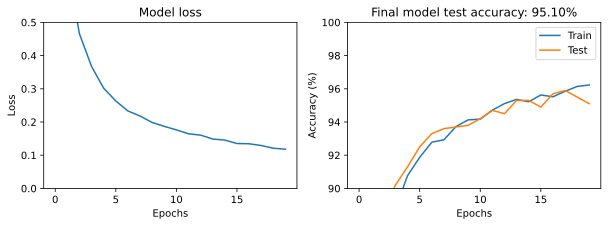

In [12]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs'), ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,.5])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs'), ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([90,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

Feature maps of Conv2d(1, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1)):


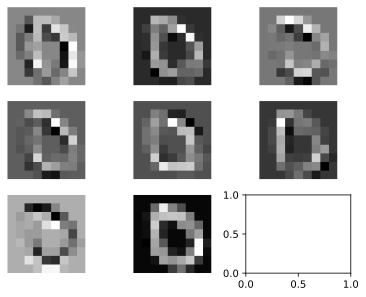

Feature maps of Conv2d(8, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)):


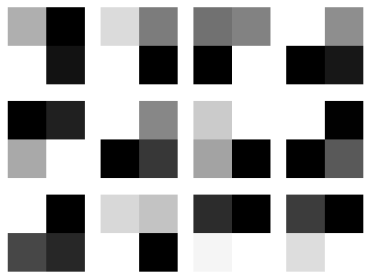

In [13]:
# Assuming that your model is called mnistNet and your input is called input
feature_maps = {}

def hook_fn(m, i, o):
    feature_maps[m] = o.detach().cpu().numpy()

# Register the hooks
net.conv1.register_forward_hook(hook_fn)
net.conv2.register_forward_hook(hook_fn)

# Forward pass
X,y = next(iter(test_loader))
with torch.no_grad(): # deactivates autograd
  output = net(X) #test data

# Plot feature maps
for layer, feature_map in feature_maps.items():
    print(f"Feature maps of {str(layer)}:")
    # feature_map has shape [N, C, H, W]
    N, C, H, W = feature_map.shape
    ncols = np.ceil(np.sqrt(C)).astype(int)
    nrows = np.ceil(C / ncols).astype(int)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    for i, ax in enumerate(axes.flat):
        if i < C:
            ax.imshow(feature_map[2, i, :, :], cmap='gray')
            ax.axis('off')
    plt.show()
